In [1]:
import os

import cv2
import matplotlib as plt
from pylab import *
%matplotlib inline
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.image_utils import img_to_array, load_img

Імпорт даних

In [2]:
test_path = 'dataset_1/test'
validation_path = 'dataset_1/validation'
train_path = 'dataset_1/train'

class_names = ['with', 'without']
image_size = (224,224)

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
# datagen = ImageDataGenerator(rescale=1.0/255.0, samplewise_center=True, samplewise_std_normalization=True,validation_split=0.99)
# data_preprocessing_f = lambda x : (x-128)/255
# data_preprocessing_f = lambda x: x
data_preprocessing_f = lambda x: preprocess_input(x)
train_batches = ImageDataGenerator(preprocessing_function=data_preprocessing_f).flow_from_directory(train_path,
                                                         target_size=image_size,
                                                         batch_size=32)

valid_batches = ImageDataGenerator(preprocessing_function=data_preprocessing_f).flow_from_directory(validation_path,
                                                         target_size=image_size,
                                                         batch_size=32)

test_batches = ImageDataGenerator(preprocessing_function=data_preprocessing_f).flow_from_directory(test_path,
                                                        target_size=image_size,
                                                        batch_size=10,
                                                        shuffle=False)

Found 165 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


VGG16 Model

In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0],image_size[1], 3), pooling='max')
base_model.summary()

2022-12-19 22:54:52.523370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 22:54:52.524364: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
for layer in base_model.layers[:-5]:
    layer.trainable = False

base_model.summary(show_trainable=True)

Model: "vgg16"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         N          
                                                                            
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      N          
                                                                            
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     N          
                                                                            
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         N          
                                                                            
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     N          
                                                                            
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [6]:
# use “get_layer” method to save the last layer of the network
# last_layer = base_model.get_layer('global_average_pooling2d')
last_layer = base_model.get_layer('global_max_pooling2d')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

x = Dropout(0.2)(last_output)
x = Dense(100, activation='relu') (x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
new_model.compile(Adam(learning_rate=0.001,decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='vgg16.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches,
                   validation_data=valid_batches, epochs=20, verbose=1, callbacks=[checkpointer])

/tmp/ipykernel_11283/1926944193.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches,


Epoch 1/20
6/6 [==============================] - 30s 5s/step - loss: 0.6790 - accuracy: 0.6061 - val_loss: 0.7015 - val_accuracy: 0.4792
Epoch 2/20
6/6 [==============================] - 29s 6s/step - loss: 0.6763 - accuracy: 0.6061 - val_loss: 0.7046 - val_accuracy: 0.4792
Epoch 3/20
6/6 [==============================] - 32s 6s/step - loss: 0.6762 - accuracy: 0.6061 - val_loss: 0.7082 - val_accuracy: 0.4792
Epoch 4/20
6/6 [==============================] - 39s 7s/step - loss: 0.6743 - accuracy: 0.6061 - val_loss: 0.7112 - val_accuracy: 0.4792
Epoch 5/20
6/6 [==============================] - 38s 6s/step - loss: 0.6728 - accuracy: 0.6061 - val_loss: 0.7142 - val_accuracy: 0.4792
Epoch 6/20
6/6 [==============================] - 27s 5s/step - loss: 0.6706 - accuracy: 0.6061 - val_loss: 0.7174 - val_accuracy: 0.4792
Epoch 7/20
6/6 [==============================] - 38s 7s/step - loss: 0.6719 - accuracy: 0.6061 - val_loss: 0.7186 - val_accuracy: 0.4792
Epoch 8/20
6/6 [==================

In [20]:
# load the weights that yielded the best validation accuracy
new_model.load_weights('vgg16.model.hdf5')

In [21]:
# evaluate test accuracy
score = new_model.evaluate(test_batches, verbose=1)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

7/7 [==============================] - 6s 759ms/step - loss: 0.6647 - accuracy: 0.9524
Test accuracy: 95.2381%


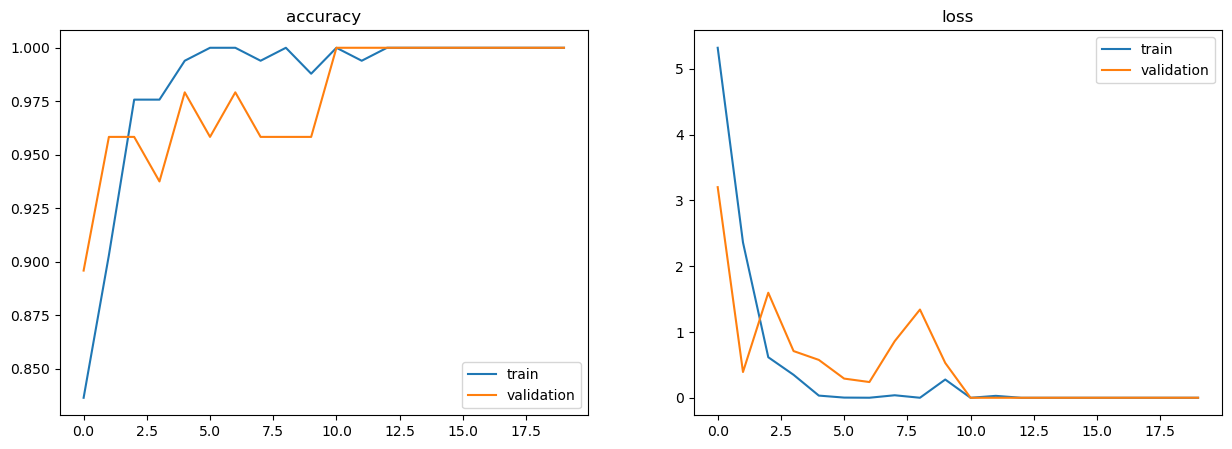

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('accuracy')
plt.subplot(122)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('loss')

plt.show()

ResNet

In [4]:
from keras.api.keras.applications import resnet50

res_model = resnet50.ResNet50(weights = "imagenet", include_top=False, input_shape = (image_size[0],image_size[1], 3), pooling='avg')
res_model.summary()

2022-12-18 18:06:49.491101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 18:06:49.492325: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [5]:
for layer in res_model.layers[:100]:
    layer.trainable = False

res_model.summary(show_trainable=True)


Model: "resnet50"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                N          
                                                                                                             
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              N          
                                )                                                                     

In [6]:
# use “get_layer” method to save the last layer of the network
last_layer = res_model.get_layer('avg_pool')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

x = Dropout(0.2)(last_output)
x = Dense(100, activation='relu') (x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_res_model = Model(inputs=res_model.input, outputs=x)

# print the new_model summary
new_res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
new_res_model.compile(Adam(learning_rate=0.0005, decay=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
new_res_model.compile(Adam(learning_rate=0.0005, decay=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='resnet.model.hdf5', save_best_only=True)

history = new_res_model.fit_generator(train_batches,
                   validation_data=valid_batches, epochs=100, verbose=1, callbacks=[checkpointer])

/tmp/ipykernel_26780/1832350346.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_res_model.fit_generator(train_batches,


Epoch 1/100
6/6 [==============================] - 26s 4s/step - loss: 0.2770 - accuracy: 0.8606 - val_loss: 4.0966 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 22s 4s/step - loss: 0.0197 - accuracy: 0.9939 - val_loss: 2.3622 - val_accuracy: 0.7708
Epoch 3/100
6/6 [==============================] - 23s 4s/step - loss: 0.0620 - accuracy: 0.9818 - val_loss: 2.1389 - val_accuracy: 0.8333
Epoch 4/100
6/6 [==============================] - 18s 3s/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 8.4219 - val_accuracy: 0.7500
Epoch 5/100
6/6 [==============================] - 20s 3s/step - loss: 0.0276 - accuracy: 0.9879 - val_loss: 11.4566 - val_accuracy: 0.7917
Epoch 6/100
6/6 [==============================] - 21s 4s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 18.9262 - val_accuracy: 0.7917
Epoch 7/100
6/6 [==============================] - 19s 3s/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 11.4708 - val_accuracy: 0.8125
Epoch 8/100
6/6 [=======

In [8]:
# load the weights that yielded the best validation accuracy
new_res_model.load_weights('resnet.model.hdf5')

In [9]:
# evaluate test accuracy
score = new_res_model.evaluate(test_batches, verbose=2)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

7/7 - 5s - loss: 0.0670 - accuracy: 0.9841 - 5s/epoch - 772ms/step
Test accuracy: 98.4127%


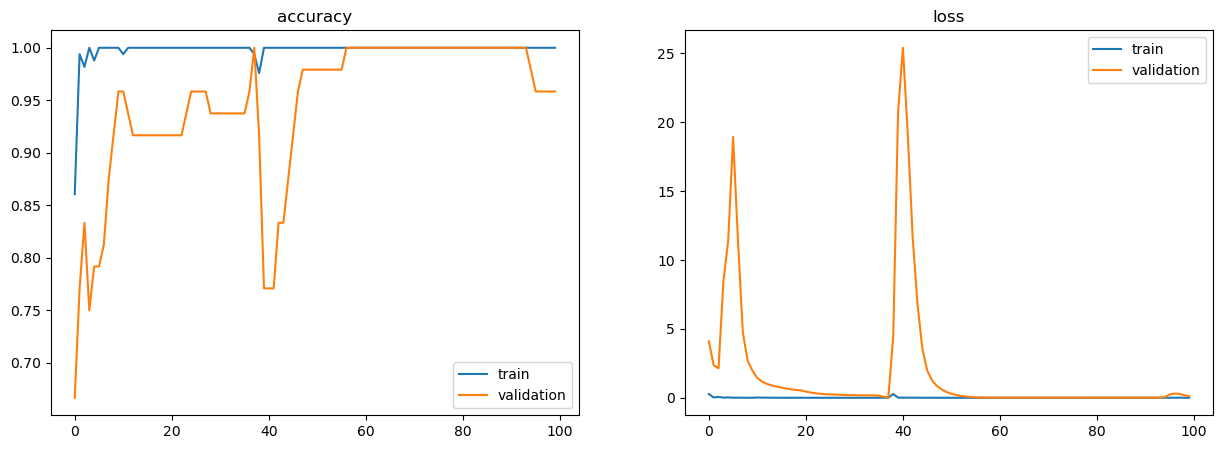

In [76]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('accuracy')
plt.subplot(122)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('loss')

plt.show()

Examples:

In [18]:
path = test_path
model = new_model

def predict_image(path, show = True):
    image = load_img(path, target_size=image_size)
    if show:
        plt.imshow(image)
        plt.show()
    image = img_to_array(image)
    input_arr = img_to_array(image)
    input_arr = np.array([input_arr])
    result = model.predict(input_arr, verbose=0)
    return np.argmax(result)

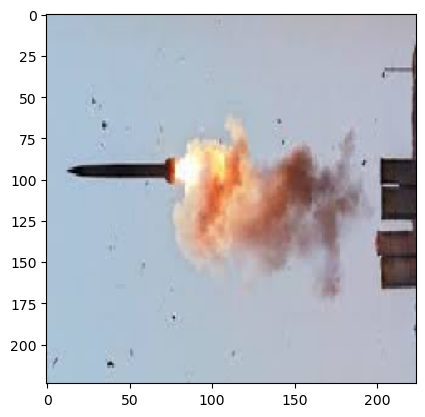

without


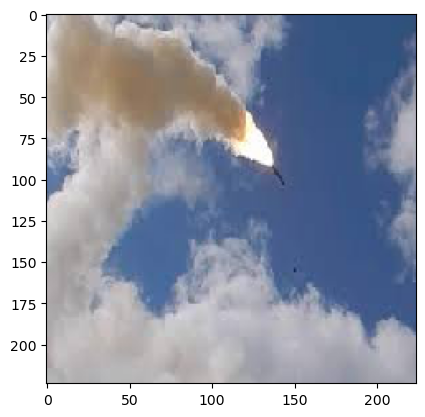

without


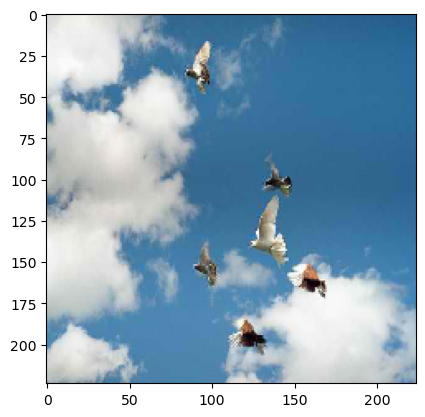

with


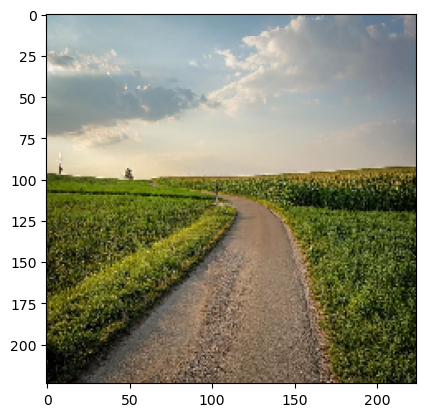

with


In [22]:
import os


for k,j in enumerate(class_names):
    for i in os.listdir(path+"/"+j):
        if(predict_image(path+"/"+j+"/"+i, show=False)!=k):
            print(class_names[predict_image(path+"/"+j+"/"+i)])
# predict_image("dataset_1/test/with/51.jpg")

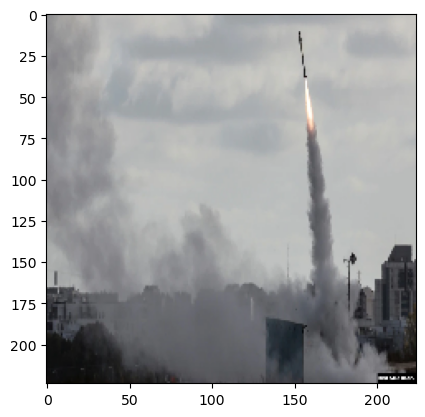

'with'

In [17]:
class_names[predict_image("dataset_1/test/with/R85.jpg")]